In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from keras import backend as K

import tensorflow as tf

In [2]:
# including Root Mean Square Error function, required for report

# loss function from demo code
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [11]:
# include weather data from South Alabama 
# Locate weather data path and create data set
WeatherDataPath = r"C:\Users\Peter Chapman\Personal_Research_Projects\weather-parameters-prediction-ML\LSTM Weather Code\Project 5 Mesonet Dataset.csv"
WeatherData = pd.read_csv(
    WeatherDataPath,
    parse_dates=['Hour'],
    index_col='Hour'
)

# second variable of interest: humidity
# relative humidity at 2 meters, which is typically used for weather reports
HumidityData = WeatherData[['RH_2m']]

# Filter out 100% humidity values (sensor saturation/overwhelms the model)
HumidityData = HumidityData[HumidityData['RH_2m'] < 100.0]

print(f"After filtering 100% values: {HumidityData.shape}")
print(f"Data after filtering - min: {HumidityData['RH_2m'].min():.2f}%, max: {HumidityData['RH_2m'].max():.2f}%")
print(f"\nFiltered data statistics:")
print(HumidityData.describe())

After filtering 100% values: (9074, 1)
Data after filtering - min: 48.88%, max: 99.90%

Filtered data statistics:
             RH_2m
count  9074.000000
mean     85.933582
std      13.019716
min      48.880000
25%      76.310000
50%      90.300000
75%      97.400000
max      99.900000


C:\RTemp\ipykernel_44800\2962116636.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  WeatherData = pd.read_csv(


In [12]:
# Normalize the humidity data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_humidity_data = scaler.fit_transform(HumidityData.values)

# Modified function to create dataset for multi-step prediction
def create_dataset(dataset, time_step=12, future_step=4): # 4 hours data from first 12 hours
    X, Y = [], []
    for i in range(len(dataset) - time_step - future_step):
        # Input: previous 'time_step' hours
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        # Output: next 'future_step' hours
        b = dataset[(i + time_step):(i + time_step + future_step), 0]
        Y.append(b)
    return np.array(X), np.array(Y)

# Create dataset with 12 input hours and 4 output hours
X, y = create_dataset(scaled_humidity_data, time_step=12, future_step=4)

# Split into train and test by 80/20 ratio, as discussed in class
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=False # want shuffle off, because time-series data
)

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# printing shapes of training data and testing data
print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training data shape: X_train=(7246, 12, 1), y_train=(7246, 4)
Testing data shape: X_test=(1812, 12, 1), y_test=(1812, 4)


In [18]:
# Build the LSTM model
model = Sequential()

# First LSTM layer with 50 units, returns sequences for stacking
model.add(LSTM(50, return_sequences=True, input_shape=(12, 1)))

# TODO: Add two additional LSTM layers
# Second LSTM layer with 50 units, returns sequences
model.add(LSTM(50, return_sequences=True))

# Third LSTM layer with 50 units, returns sequences
model.add(LSTM(50, return_sequences=True))

# Fourth LSTM layer with 50 units, does not return sequences
model.add(LSTM(50, return_sequences=False))

# TODO: Add Dropout layers
# Dropout layer to prevent overfitting (20% dropout rate)
model.add(Dropout(0.2))

# TODO: Add Dense layer with ReLU as activation function
# Dense layer with 25 neurons and ReLU activation
model.add(Dense(25, activation='relu'))

# Additional Dense layer with 25 neurons
model.add(Dense(25))

# Output layer with 4 neurons (predicting 4 future hours)
model.add(Dense(4))

# Compile the model
# TODO: Change to two different optimizers other than Adam
# Using RMSprop optimizer as alternative to Adam
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005)

model.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error', rmse]
)

# Display model architecture
model.summary()

c:\Users\Peter Chapman\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 12, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 12, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,029 (285.27 KB)

 Trainable params: 73,029 (285.27 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the model
num_epochs = 45
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=num_epochs,
    batch_size=32,
    verbose=1
)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual humidity values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate Mean Square Error for training and testing
train_mse = np.mean((y_train_actual - train_predict) ** 2)
test_mse = np.mean((y_test_actual - test_predict) ** 2)


# printing training and testing errors
print(f"\n===== Humidity Model Results =====")
print(f"Training MSE: {train_mse:.4f}")
print(f"Testing MSE: {test_mse:.4f}")
print(f"Training RMSE: {np.sqrt(train_mse):.4f}")
print(f"Testing RMSE: {np.sqrt(test_mse):.4f}")

Epoch 1/45
227/227 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.0361 - mean_absolute_error: 0.1288 - mean_squared_error: 0.0361 - rmse: 0.1512 - val_loss: 0.0060 - val_mean_absolute_error: 0.0672 - val_mean_squared_error: 0.0060 - val_rmse: 0.0717
Epoch 2/45
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0090 - mean_absolute_error: 0.0753 - mean_squared_error: 0.0090 - rmse: 0.0905 - val_loss: 0.0027 - val_mean_absolute_error: 0.0419 - val_mean_squared_error: 0.0027 - val_rmse: 0.0466
Epoch 3/45
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0073 - mean_absolute_error: 0.0679 - mean_squared_error: 0.0073 - rmse: 0.0813 - val_loss: 0.0026 - val_mean_absolute_error: 0.0406 - val_mean_squared_error: 0.0026 - val_rmse: 0.0463
Epoch 4/45
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0060 - mean_absolute_error: 0.0612 - mean_squared_error: 0.0060 - rmse: 0.0742 - val_loss: 0.0123 - val_mean_absolute_error: 0.1032 - val_mean_squared_error: 0.0123 - val_rmse: 0.1072
Epoch 5/45


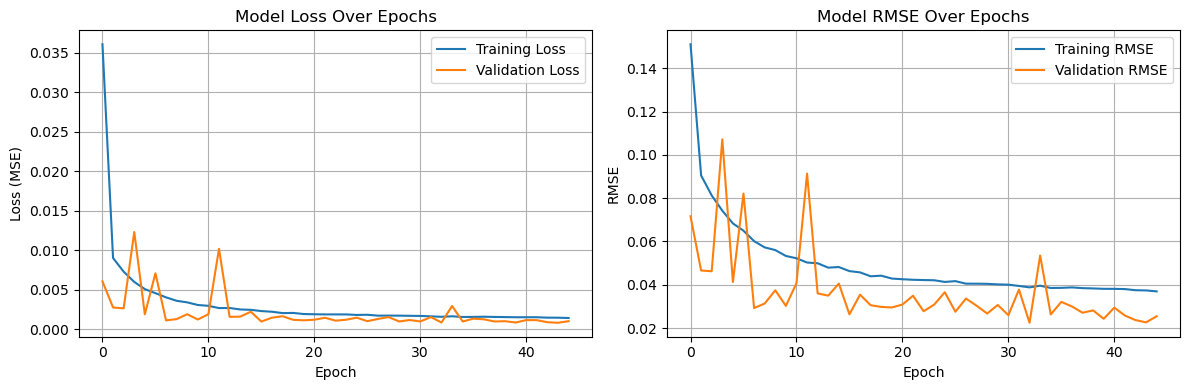

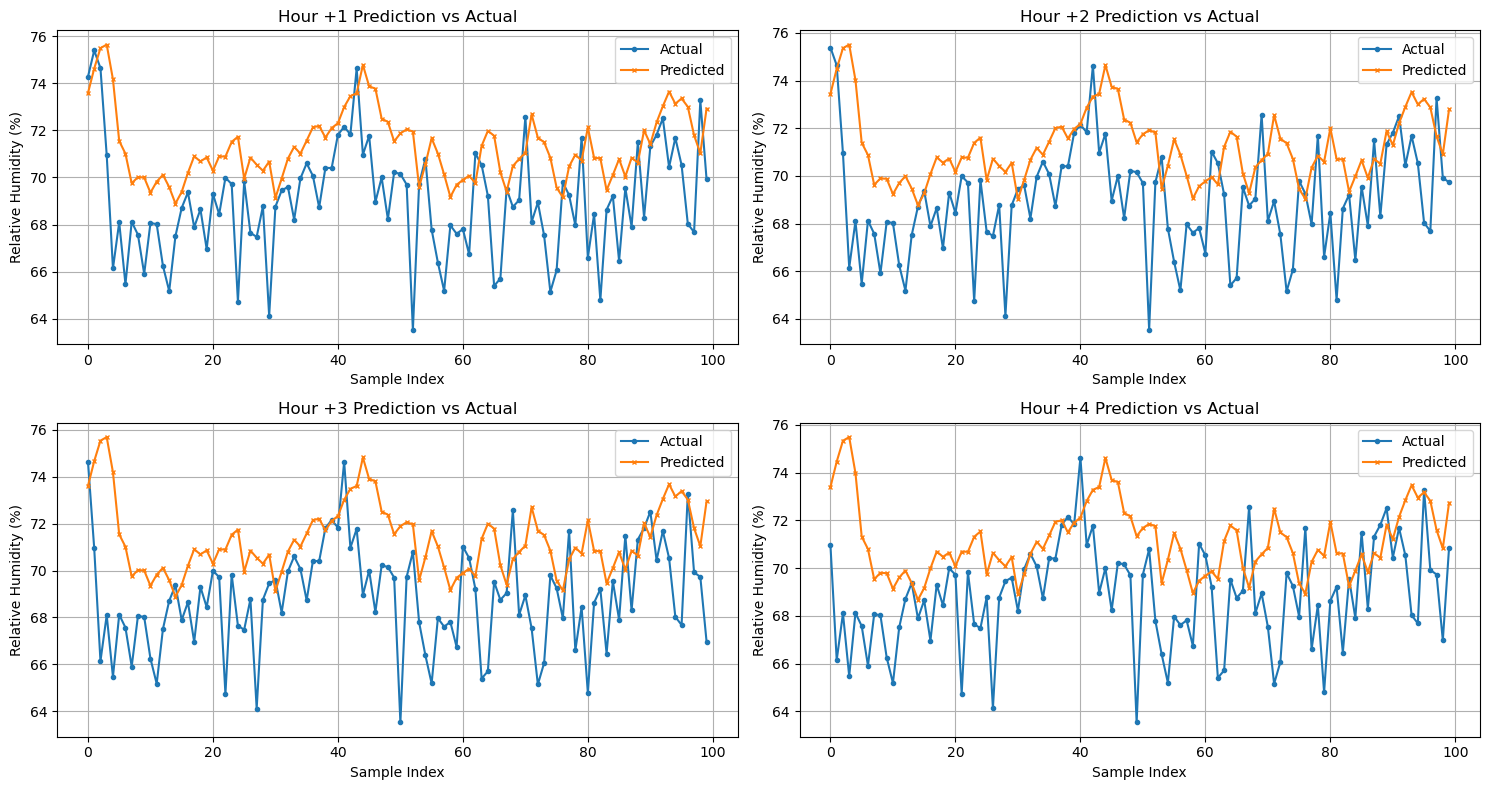

In [20]:
# Plotting model losses and predictions

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['rmse'], label='Training RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Model RMSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot sample predictions vs actual (first 100 test samples)
plt.figure(figsize=(15, 8))
num_samples = min(100, len(test_predict))

for hour in range(4):
    plt.subplot(2, 2, hour + 1)
    plt.plot(y_test_actual[:num_samples, hour], label='Actual', marker='o', markersize=3)
    plt.plot(test_predict[:num_samples, hour], label='Predicted', marker='x', markersize=3)
    plt.title(f'Hour +{hour+1} Prediction vs Actual')
    plt.xlabel('Sample Index')
    plt.ylabel('Relative Humidity (%)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()